In [1092]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib as jb

In [1093]:
data = pd.read_csv("premier_league.csv")

In [1094]:
data.dropna(inplace=True)

In [1095]:
football_data = data.copy()
del football_data['SourceFile']
football_data['Date'] = pd.to_datetime(football_data['Date'], errors='coerce') 



/var/folders/fw/ff0yxbkj4png1_vbc9rxswcm0000gn/T/ipykernel_90187/696082657.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  football_data['Date'] = pd.to_datetime(football_data['Date'], errors='coerce')


In [1096]:
all_teams = pd.concat([football_data['HomeTeam'], football_data['AwayTeam']])
team_encoder = LabelEncoder()
ref_encoder = LabelEncoder()
team_encoder.fit(all_teams)

football_data['HomeID'] = team_encoder.transform(football_data['HomeTeam'])
football_data['AwayID'] = team_encoder.transform(football_data['AwayTeam'])
football_data['RefereeID'] = ref_encoder.fit_transform(football_data['Referee'])


football_data['Month'] = football_data['Date'].dt.month
football_data['Year'] = football_data['Date'].dt.year


In [1097]:
result_map = {'H': 1, 'D': 0, 'A': -1}
football_data['Result'] = football_data['FTR'].map(result_map)
football_data['HResult'] = football_data['HTR'].map(result_map)
football_data = football_data.sort_values("Date")
football_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AY,HR,AR,HomeID,AwayID,RefereeID,Month,Year,Result,HResult
9967,2000-01-10,Arsenal,Man United,1,0,H,1.0,0.0,H,Graham Barber,...,3.0,0.0,0.0,0,27,64,1,2000,1,1
9968,2000-01-10,Chelsea,Liverpool,3,0,H,2.0,0.0,H,Dermot Gallagher,...,1.0,0.0,0.0,13,24,45,1,2000,1,1
9969,2000-01-10,Sunderland,Leicester,0,0,D,0.0,0.0,D,Steve Lodge,...,1.0,0.0,0.0,38,23,162,1,2000,0,0
10043,2000-02-12,Ipswich,Derby,0,1,A,0.0,1.0,A,Mark Halsey,...,1.0,0.0,0.0,21,16,104,2,2000,-1,-1
10047,2000-02-12,West Ham,Middlesbrough,1,0,H,1.0,0.0,H,Roy Burton,...,4.0,0.0,1.0,43,28,145,2,2000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2025-09-03,Man United,Arsenal,1,1,D,1.0,0.0,H,A Taylor,...,1.0,0.0,0.0,27,0,4,9,2025,0,1
2938,2025-09-03,Tottenham,Bournemouth,2,2,D,0.0,1.0,A,J Brooks,...,3.0,0.0,0.0,40,6,70,9,2025,0,-1
2937,2025-09-03,Chelsea,Leicester,1,0,H,0.0,0.0,D,T Robinson,...,0.0,0.0,0.0,13,23,167,9,2025,1,0
2940,2025-10-03,West Ham,Newcastle,0,1,A,0.0,0.0,D,M Salisbury,...,1.0,0.0,0.0,43,29,97,10,2025,-1,0


In [1098]:
def calculate_team_form(df, team_name, match_date, N=5):
  
    past_matches = df[
        ((df['HomeTeam'] == team_name) | (df['AwayTeam'] == team_name)) &
        (df['Date'] < match_date)
    ].sort_values(by='Date', ascending=False).head(N)
    
    goals_scored = []
    goals_conceded = []
    results = []

    for _, row in past_matches.iterrows():
        if row['HomeTeam'] == team_name:
            goals_scored.append(row['FTHG'])
            goals_conceded.append(row['FTAG'])
            results.append(row['Result'])
        else:
            goals_scored.append(row['FTAG'])
            goals_conceded.append(row['FTHG'])
            results.append(-row['Result']) 

    if len(past_matches) == 0:
        return pd.Series([0, 0, 0])  
    
    avg_goals = np.mean(goals_scored)
    avg_conceded = np.mean(goals_conceded)
    win_rate = sum(1 for r in results if r == 1) / len(results)

    return pd.Series([avg_goals, avg_conceded, win_rate])


In [1099]:
home_form_stats = football_data.apply(
    lambda row: calculate_team_form(football_data, row['HomeTeam'], row['Date']),
    axis=1
)

away_form_stats = football_data.apply(
    lambda row: calculate_team_form(football_data, row['AwayTeam'], row['Date']),
    axis=1
)

# Assign column names
home_form_stats.columns = ['HomeAvgGoals', 'HomeAvgConceded', 'HomeWinRate']
away_form_stats.columns = ['AwayAvgGoals', 'AwayAvgConceded', 'AwayWinRate']

# Merge into original dataset
football_data = pd.concat([football_data, home_form_stats, away_form_stats], axis=1)
football_data


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,Month,Year,Result,HResult,HomeAvgGoals,HomeAvgConceded,HomeWinRate,AwayAvgGoals,AwayAvgConceded,AwayWinRate
9967,2000-01-10,Arsenal,Man United,1,0,H,1.0,0.0,H,Graham Barber,...,1,2000,1,1,0.0,0.0,0.0,0.0,0.0,0.0
9968,2000-01-10,Chelsea,Liverpool,3,0,H,2.0,0.0,H,Dermot Gallagher,...,1,2000,1,1,0.0,0.0,0.0,0.0,0.0,0.0
9969,2000-01-10,Sunderland,Leicester,0,0,D,0.0,0.0,D,Steve Lodge,...,1,2000,0,0,0.0,0.0,0.0,0.0,0.0,0.0
10043,2000-02-12,Ipswich,Derby,0,1,A,0.0,1.0,A,Mark Halsey,...,2,2000,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0
10047,2000-02-12,West Ham,Middlesbrough,1,0,H,1.0,0.0,H,Roy Burton,...,2,2000,1,1,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2939,2025-09-03,Man United,Arsenal,1,1,D,1.0,0.0,H,A Taylor,...,9,2025,0,1,2.0,1.2,0.4,0.6,0.6,0.2
2938,2025-09-03,Tottenham,Bournemouth,2,2,D,0.0,1.0,A,J Brooks,...,9,2025,0,-1,0.8,1.4,0.2,1.0,1.4,0.2
2937,2025-09-03,Chelsea,Leicester,1,0,H,0.0,0.0,D,T Robinson,...,9,2025,1,0,0.8,0.6,0.4,0.2,2.8,0.0
2940,2025-10-03,West Ham,Newcastle,0,1,A,0.0,0.0,D,M Salisbury,...,10,2025,-1,0,1.4,1.8,0.2,1.8,2.0,0.6


In [1100]:
corr_matrix = football_data.copy()
corr_matrix.drop(columns=corr_matrix.select_dtypes(exclude=[np.number]).columns, inplace=True)
corr_matrix.corr()['Result']

FTHG               0.629446
FTAG              -0.634846
HTHG               0.432407
HTAG              -0.423077
HS                 0.223281
AS                -0.255046
HST                0.321879
AST               -0.320303
HF                -0.032866
AF                 0.028696
HC                 0.054425
AC                -0.044678
HY                -0.118736
AY                 0.029200
HR                -0.129953
AR                 0.092119
HomeID            -0.056779
AwayID             0.066347
RefereeID          0.023378
Month             -0.025197
Year              -0.038417
Result             1.000000
HResult            0.596498
HomeAvgGoals       0.171671
HomeAvgConceded   -0.148022
HomeWinRate        0.174535
AwayAvgGoals      -0.182958
AwayAvgConceded    0.119770
AwayWinRate       -0.174111
Name: Result, dtype: float64

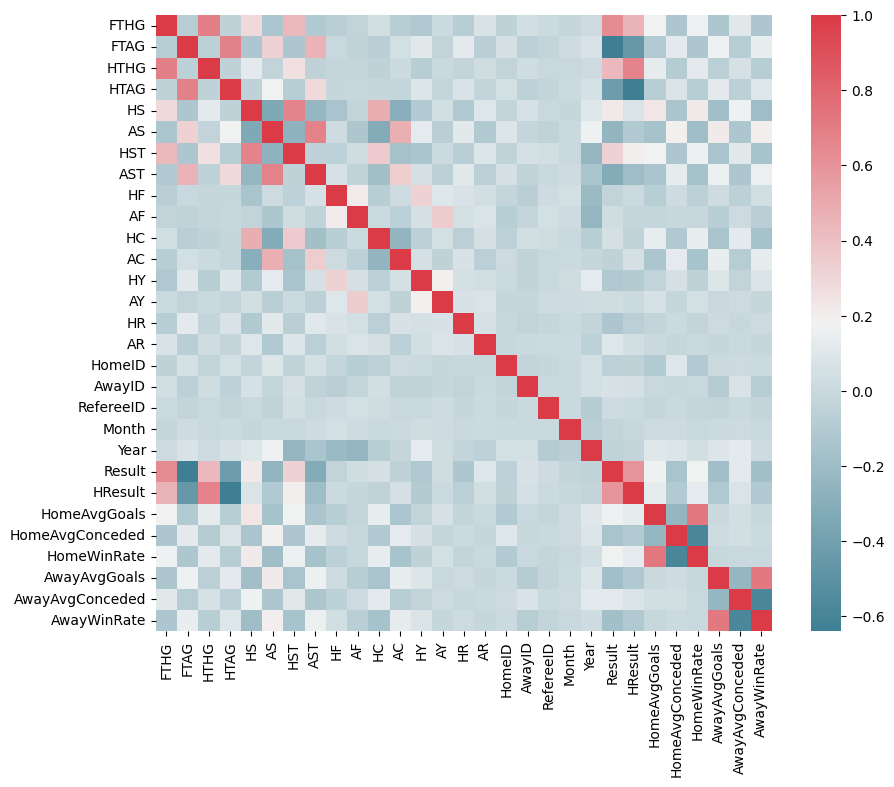

In [1101]:
f, ax = plt.subplots(figsize=(10, 8))
corr = corr_matrix.corr()

sns.heatmap(corr, 
            mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True,
            ax=ax)
plt.show()

In [1102]:
from sklearn.ensemble import RandomForestClassifier

In [1103]:
rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, random_state=1)

In [1104]:
train = football_data[football_data["Date"] < '2022-01-01']
test = football_data[football_data["Date"] > '2022-01-01']

In [1105]:
# predictors = ["HomeID", "AwayID", "HResult", "RefereeID", "Month", "Year","FTHG","HTHG","AR","AY","HC","AF","HST","HS"]
# predictors = ["HomeID", "AwayID", "RefereeID", "Month", "Year"]
predictors = [
    "HomeID", "AwayID", "RefereeID", "Month", "Year",
    "HomeAvgGoals", "HomeAvgConceded", "HomeWinRate",
    "AwayAvgGoals", "AwayAvgConceded", "AwayWinRate"
]


In [1106]:
rf.fit(train[predictors], train["Result"])

RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=1)

In [1107]:
preds = rf.predict(test[predictors])

In [1108]:
from sklearn.metrics import accuracy_score

In [1109]:
acc = accuracy_score(test["Result"], preds)

In [1110]:
acc

0.503562945368171

In [1111]:
combine = pd.DataFrame(dict(actual=test["Result"], prediction=preds))

In [1112]:
pd.crosstab(index=combine["actual"], columns=combine["prediction"])

prediction,-1,0,1
actual,,,
-1,196,23,189
0,96,26,163
1,129,27,414


In [1113]:
def predict_match_with_form(home_team, away_team, referee, match_date_str):
    match_date = pd.to_datetime(match_date_str)
    
    # Encode team & referee
    try:
        home_id = team_encoder.transform([home_team])[0]
        away_id = team_encoder.transform([away_team])[0]
    except ValueError:
        print("❗ Unknown team name.")
        return
    
    referee_id = (
        ref_encoder.transform([referee])[0]
        if referee in ref_encoder.classes_
        else -1
    )
    
    # Get form for each team before the match
    home_form = calculate_team_form(football_data, home_team, match_date)
    away_form = calculate_team_form(football_data, away_team, match_date)
    
    # Build feature row
    row = pd.DataFrame([{
        "HomeID": home_id,
        "AwayID": away_id,
        "RefereeID": referee_id,
        "Month": match_date.month,
        "Year": match_date.year,
        "HomeAvgGoals": home_form[0],
        "HomeAvgConceded": home_form[1],
        "HomeWinRate": home_form[2],
        "AwayAvgGoals": away_form[0],
        "AwayAvgConceded": away_form[1],
        "AwayWinRate": away_form[2],
    }])
    
    pred = rf.predict(row)[0]
    result_map = {1: "🏠 Home Win", 0: "🤝 Draw", -1: "✈️ Away Win"}
    
    print(f"🔮 Prediction for {home_team} vs {away_team} on {match_date.date()}: {result_map[pred]}")



In [1114]:
predict_match_with_form("Brentford", "Brighton", "T Robinson", "2025-04-19")


🔮 Prediction for Brentford vs Brighton on 2025-04-19: 🏠 Home Win
